In [59]:
from bs4 import BeautifulSoup
import bs4
import requests
import requests_cache
import re
import pandas as pd
import seaborn as sns

requests_cache.install_cache("bases_scraping", expire_after=10e5)

In [49]:
prixs = []
surfaces = []
types = []
pieces = []
cps = []
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

In [50]:
url = f"https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&tbApp=1&tbDup=1&tbChb=1&tbLof=1&tbAtl=1&tbPla=1&tbMai=1&tbVil=1&tbCha=1&tbPro=1&tbHot=1&tbMou=1&tbFer=1&at=1&pa=FR&lol=0&ray=50&codeINSEE=35XX0,"
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

In [55]:
def get_nb_pages():
    string = soup.find("div", class_="resume").span.text
    a = int(string.split("-")[0])
    b = int(string.split("-")[1].split("sur")[0])
    c = int(string.split("-")[1].split("sur")[1].replace("annonces",""))    
    return c // (b-a)

nb_pages = get_nb_pages()

1 - 25 sur 372 annonces


In [56]:
for i in range(1,nb_pages+1):
    url = f"https://www.paruvendu.fr/immobilier/annonceimmofo/liste/listeAnnonces?tt=1&tbApp=1&tbDup=1&tbChb=1&tbLof=1&tbAtl=1&tbPla=1&tbMai=1&tbVil=1&tbCha=1&tbPro=1&tbHot=1&tbMou=1&tbFer=1&at=1&pa=FR&lol=0&ray=50&codeINSEE=35XX0,,&p={i}"
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    
    for annonce in soup.find_all('div', class_="ergov3-annonce"):
        # prix du bien
        prix = annonce.find('div', class_="ergov3-priceannonce")
        prix = int(prix.text.replace(" ","").replace("€","").replace("\n","").replace("*","").replace("\r",""))
        #print(re.sub(r'(\s+){2,}|(\*)', ' ', annonce.find('div', class_='ergov3-priceannonce').text))

        # Titre de l'annonce. Permet de déduire le nombre de pièce, la surface et le type de bien
        txt = annonce.find('div', class_="ergov3-txtannonce")
        #print(re.sub(r"""[!?'".<>(){}@%&*/[/]""", " ",txt.h3.text ))
        # type de bien
        type_bien = txt.h3.text.split('\r\n')[1]

        # nombre de pièce du bien
        nb_pieces = txt.h3.text.split('\r\n')[2]

        # surface du bien
        surface = txt.h3.span.text.split(",")[-1].split("-")[-1].replace("m²","").replace(" ","").replace("\t","").replace("\n","").replace("\r","").replace("carrez","")

        # Code postal de l'annonce
        #cp = txt.cite.text.replace("(","").replace(")","").split(' ')[1].replace("\t","").replace("\n","").replace("\r","")
        cp = re.sub(r'\r\n','',txt.cite.text)

        # Ajout des caractéristiques dans des tableaux
        try:
            price = int(price)
            surface = int(surface)
            nb_pieces = int(nb_pieces)
            #type_bien = str(type_bien)
            #cps = int(cp)

            prices.append(price)
            surfaces.append(surface)
            pieces.append(nb_pieces)
            types.append(type_bien)
            cps.append(cp)

        except Exception as e:
            print(e)

df = pd.DataFrame(data={
    "price": prices,
    "surface": surfaces,
    "pieces": pieces,
    "types": types,
    "code postal": cps,
})
df["prix au m2"] = df["price"]/df["surface"]
df

invalid literal for int() with base 10: '92Appartement5pièces'
invalid literal for int() with base 10: 'Sud3'
invalid literal for int() with base 10: 'Ouest3'
invalid literal for int() with base 10: '92Appartement5pièces'
invalid literal for int() with base 10: '65Appartement3pièces'
invalid literal for int() with base 10: 'valeurvideàdéfinir2'
invalid literal for int() with base 10: '62Appartement3pièces'
invalid literal for int() with base 10: 'valeurvideàdéfinir2'
invalid literal for int() with base 10: '122Maison5pièces'
invalid literal for int() with base 10: 'Sud3'
invalid literal for int() with base 10: '62Appartement3pièces'
invalid literal for int() with base 10: '40Appartement2pièces'
invalid literal for int() with base 10: '122Maison5pièces'
invalid literal for int() with base 10: 'Sud3'
invalid literal for int() with base 10: '92Appartement5pièces'
invalid literal for int() with base 10: '122Maison5pièces'
invalid literal for int() with base 10: 'Est'
invalid literal for in

,price,surface,pieces,types,code postal,prix au m2
0,300000,97,4,Appartement,Rennes (35200),3092.783505
1,109900,19,1,Appartement,Rennes (35000),5784.210526
2,370000,96,5,Appartement,Rennes (35000),3854.166667
3,220500,47,2,Appartement,Rennes (35000),4691.489362
4,1520035,255,4,Appartement,Rennes (35000),5960.921569
...,...,...,...,...,...,...
361,496000,89,4,Appartement,Rennes (35000),5573.033708
362,348500,60,3,Appartement,Rennes (35000),5808.333333
363,298000,57,3,Appartement,Rennes (35000),5228.070175
364,145000,24,1,Appartement,Rennes (35000),6041.666667


In [57]:
df.groupby("pieces").mean()

,price,surface,prix au m2
pieces,,,
1,1.433568e+05,24.384615,5986.127645
2,2.122840e+05,48.714286,4749.445946
3,3.000058e+05,65.797980,4545.924551
4,4.230818e+05,92.469388,4492.394039
5,4.795584e+05,111.120000,4256.989345
6,7.481857e+05,154.071429,4666.493804
7,8.112951e+05,173.500000,4616.929156
8,8.691214e+05,204.571429,4178.916630
9,1.268633e+06,205.000000,5876.137304


In [58]:
df.groupby("code postal").mean()

,price,surface,pieces,prix au m2
code postal,,,,
Rennes (35000),400301.882353,87.328173,3.684211,4689.271551
Rennes (35200),325088.789474,89.210526,4.157895,3626.685213
Rennes (35700),344671.750000,78.750000,3.583333,4590.833062


C:\Users\aandre\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prix au m2'>

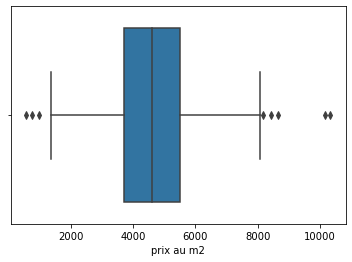

In [61]:
sns.boxplot(df["prix au m2"])

In [69]:
filtre = (df["code postal"] == "Rennes (35000)") & (df["pieces"] == 1)


df_filtre = df.loc[filtre]

C:\Users\aandre\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prix au m2'>

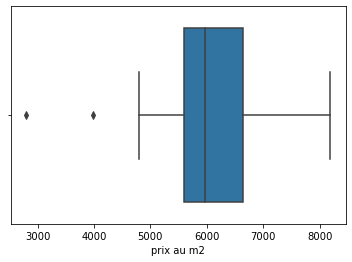

In [70]:
sns.boxplot(df_filtre["prix au m2"])

In [ ]:
sns.boxplot(df_filtre["prix au m2"])

In [71]:
df_filtre.sort_values(by="prix")

,price,surface,pieces,types,code postal,prix au m2
275,82900,15,1,Appartement,Rennes (35000),5526.666667
236,95000,34,1,Appartement,Rennes (35000),2794.117647
119,103000,19,1,Appartement,Rennes (35000),5421.052632
1,109900,19,1,Appartement,Rennes (35000),5784.210526
7,113184,20,1,Appartement,Rennes (35000),5659.200000
58,125700,22,1,Appartement,Rennes (35000),5713.636364
5,131000,16,1,Appartement,Rennes (35000),8187.500000
281,131000,21,1,Appartement,Rennes (35000),6238.095238
324,131500,33,1,Appartement,Rennes (35000),3984.848485
123,137000,26,1,Appartement,Rennes (35000),5269.230769
